# Flux analysis, methionine tracing

In [1]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.stats import norm
import sys

In [2]:
#  path to simpleflux package 
sys.path.append('C:/code/python/simpleflux/src')
from simpleflux.model import FluxModel, FluxState
from simpleflux.modelstate import ModelState
from simpleflux.fitting import ModelFit

In [3]:
input_data_path = Path('00_input_data')
heavy_fractions_path = Path('02_heavy_fractions')
results_path = Path('03_met_flux_analysis')

In [4]:
# make matplotlib use TrueType fonts for PDF export
matplotlib.rcParams['pdf.fonttype'] = 42

In [5]:
np.set_printoptions(precision=3, suppress=True)

## Define functions

In [6]:
def prepend_index_level(df: pd.DataFrame, values, name: str) -> pd.DataFrame:
    return df.assign(**{name: values}).set_index(name, append=True).swaplevel()

In [7]:
def plot_model_fit(flux_model: FluxModel, x_predicted: pd.DataFrame,
                   heavy_fractions: pd.DataFrame, use_log_scale: bool = False) -> None:
    y_axis_margin = 0.05
    fig, axs = plt.subplots(ncols=len(flux_model.metabolites), figsize=(15,3))
    for i, metabolite in enumerate(flux_model.metabolites):
        axs[i].plot(x_predicted[metabolite])
        if metabolite in heavy_fractions.columns:
            axs[i].plot(heavy_fractions[metabolite], '.')
        axs[i].set_ylim(-y_axis_margin, 1 + y_axis_margin)
        axs[i].set_title(metabolite)
        if use_log_scale:
            axs[i].set_xscale('log')
            axs[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            axs[i].set_xlim(heavy_fractions.index.min() / 2, heavy_fractions.index.max())
        axs[i].set_xticks(heavy_fractions.index)

In [8]:
def plot_file_name(cell_type: str, log_scale: bool) -> str:
    plot_name = 'met_fitted_data'
    if log_scale:
        scale_suffix = 'logscale'
    else:
        scale_suffix = 'linscale'
    return "_".join([cell_type, plot_name, scale_suffix]) + '.pdf'

In [9]:
def confidence_intervals_table(model_fit: ModelFit, ci_level: float) -> pd.DataFrame:
    fitted_net_fluxes = model_fit.model_state.flux_state.net_fluxes
    net_flux_std_err = model_fit.fitted_fluxes_std_err()
    ci_scale_factor = norm.isf((1 -ci_level)/2)
    return pd.DataFrame(
        {
            'net': fitted_net_fluxes,
            'std err': net_flux_std_err,
            'ci_half-width': net_flux_std_err*ci_scale_factor,
            'ci_lower': fitted_net_fluxes - net_flux_std_err*ci_scale_factor,
            'ci_upper': fitted_net_fluxes + net_flux_std_err*ci_scale_factor,
        },
        index=pd.Index(flux_model.reactions, name='reaction')
    )

## Define model

### Stoichiometry

In [10]:
stoichiometry = defaultdict(int, {
    ('MET_IN', 'met'): 1,
    ('PROT_SYNTH', 'met'): -1, ('PROT_SYNTH', 'metp'): 1, 
    ('AHCY', 'sah'): -1, ('AHCY', 'hcys'): 1, 
    ('METS', 'hcys'): -1, ('METS', 'met'): 1, 
    ('MAT', 'met'): -1, ('MAT', 'sam'): 1, 
    ('SAM_METH', 'sam'): -1, ('SAM_METH', 'sah'): 1, 
    ('CYSTS', 'hcys'): -1, ('CYSTS', 'cyst'): 1,
    ('CYSTL', 'cyst'): -1, ('CYSTL', 'akb'): 1,
    ('HCYS_OUT', 'hcys'): -1,
    ('PROT_OUT', 'metp'): -1,
    ('AKB_OUT', 'akb'): -1,
})

reversible_reactions = [
    'MET_IN',
    'PROT_SYNTH',
    'AHCY',
    'CYSTL',
]

free_reactions = ['CYSTS', 'METS', 'PROT_OUT', 'SAM_METH']

flux_model = FluxModel(stoichiometry, reversible_reactions, free_reactions)

In [11]:
flux_model.get_stoichiometry_df()

,AHCY,AKB_OUT,CYSTL,CYSTS,HCYS_OUT,MAT,METS,MET_IN,PROT_OUT,PROT_SYNTH,SAM_METH
akb,0,-1,1,0,0,0,0,0,0,0,0
cyst,0,0,-1,1,0,0,0,0,0,0,0
hcys,1,0,0,-1,-1,0,-1,0,0,0,0
met,0,0,0,0,0,-1,1,1,0,-1,0
metp,0,0,0,0,0,0,0,0,-1,1,0
sah,-1,0,0,0,0,0,0,0,0,0,1
sam,0,0,0,0,0,1,0,0,0,0,-1


## U-13C-methionine tracing

### Pool sizes

Estimated intracellular concentrations in uM

NOTE: we might leave out akb here

In [12]:
pool_size_data = pd.read_csv(input_data_path / 'U13C-met_concentrations.csv', sep=';', index_col=[0, 1])
pool_size_data

mean  std_dev
cell_type metabolite                  
BJ-TERT   hcys           10.0    10.00
          met           739.0     6.74
          sam            72.3     6.79
          sah             2.5     0.07
          cyst           16.3     0.90
          metp        23500.0  2350.00
          akb          1000.0  1000.00
BJ-RAS    hcys           10.0    10.00
          met           573.8    59.92
          sam           148.9    20.57
          sah             2.3     0.06
          cyst           16.3     0.90
          metp        23500.0  2350.00
          akb          1000.0  1000.00

### Measured fluxes

Measured fluxes (pmol / h * uL cells = uM / h).

In [13]:
measured_fluxes = pd.read_csv(input_data_path / 'U13C-met_measured_fluxes.csv', sep=';', index_col=[0, 1])
measured_fluxes

mean  std_dev
cell_type flux                   
BJ-TERT   PROT_OUT   416     83.0
          HCYS_OUT   115     11.5
BJ-RAS    PROT_OUT   520    104.0
          HCYS_OUT   106     10.6

### Heavy fractions

In [14]:
heavy_fractions = pd.read_csv(heavy_fractions_path / '13C-met_heavy_fractions.csv', index_col=[0, 1, 2])
# use time in hours
heavy_fractions.index = heavy_fractions.index\
    .set_levels(heavy_fractions.index.levels[1].astype('float64') / 60, level=1)\
    .rename(['cell_type', 'time_hours', 'replicate_nr'])
heavy_fractions.head(5)

cyst       met       sam
cell_type time_hours replicate_nr                                  
BJ-RAS    0.083333   1            -4.730827e-07  0.947336  0.128583
                     2            -4.730827e-07  0.958151  0.154254
          0.250000   1            -4.730827e-07  0.972891  0.475179
                     2            -4.730827e-07  0.970010  0.479771
          0.500000   1            -4.730827e-07  0.970564  0.735455

In [15]:
heavy_fraction_mean = heavy_fractions.groupby(level=[0, 1]).mean()
heavy_fraction_mean

cyst       met       sam
cell_type time_hours                                  
BJ-RAS    0.083333   -4.730827e-07  0.952744  0.141419
          0.250000   -4.730827e-07  0.971451  0.477475
          0.500000   -4.730827e-07  0.972464  0.743137
          1.000000   -4.730827e-07  0.972576  0.878904
          5.000000    3.797082e-01  0.984947  0.958616
          24.000000   7.779678e-01  0.976280  0.973534
BJ-TERT   0.083333   -4.730827e-07  0.965920  0.146616
          0.250000   -4.730827e-07  0.971597  0.468725
          0.500000   -4.730827e-07  0.977344  0.780345
          1.000000    1.283193e-01  0.976847  0.938402
          5.000000    6.647575e-01  0.982441  0.978226
          24.000000   7.412110e-01  0.973523  0.974370

In [16]:
min_std_dev = 0.02
heavy_fraction_sd = np.maximum(heavy_fractions.groupby(level=[0, 1]).std(), min_std_dev)
heavy_fraction_sd

cyst   met   sam
cell_type time_hours                      
BJ-RAS    0.083333    0.020000  0.02  0.02
          0.250000    0.020000  0.02  0.02
          0.500000    0.020000  0.02  0.02
          1.000000    0.020000  0.02  0.02
          5.000000    0.034009  0.02  0.02
          24.000000   0.035625  0.02  0.02
BJ-TERT   0.083333    0.020000  0.02  0.02
          0.250000    0.020000  0.02  0.02
          0.500000    0.020000  0.02  0.02
          1.000000    0.023403  0.02  0.02
          5.000000    0.046440  0.02  0.02
          24.000000   0.020000  0.02  0.02

### Initial flux state

In [17]:
init_flux_state = FluxState.from_dict(
    flux_model,
    free_fluxes={
        'CYSTS' : 7,
        'METS': 85,
        'SAM_METH': 110,
        'PROT_OUT': 400,
    },
    exchanges={
        'MET_IN' : 0.9,
        'PROT_SYNTH': 0.4,
        'AHCY': 0.4,
        'CYSTL': 0.4,
    }
)

In [18]:
initial_state = ModelState(
    model=flux_model,
    flux_state=init_flux_state,
    concentrations=pool_size_data.loc['BJ-TERT'].loc[flux_model.metabolites, 'mean'].to_numpy(),
    medium_mi={'MET_IN': 1.0}
)

### Fit model

In [19]:
cell_types = ['BJ-TERT', 'BJ-RAS']

In [20]:
model_fits = {
    cell_type: ModelFit(
        initial_state,
        measured_mi = heavy_fraction_mean.loc[cell_type],
        measured_mi_std_dev = heavy_fraction_sd.loc[cell_type],
        measured_fluxes=measured_fluxes.loc[cell_type],
        measured_conc=pool_size_data.loc[cell_type]
    )
    for cell_type in cell_types
}

Initial residuals

In [21]:
[model_fits[cell_type].model_residual() for cell_type in cell_types]

[array([-0.002, 29.601,  6.098, -0.111, 12.11 , 15.883, -0.942,  4.578,
        20.703,  1.336,  2.231, 13.846,  2.81 ,  1.731,  1.604,  5.552,
         0.247,  0.317,  0.193,  8.435,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ]),
 array([-0.002, 28.942,  5.839, -0.111, 12.103, 16.321, -0.942,  4.334,
        18.843, -4.853,  2.017, 10.871, -4.545,  1.857,  0.623,  4.149,
         0.385,  0.276,  1.154,  8.302,  0.   , -2.757,  3.724, -3.333,
         0.   ,  0.   ,  0.   ])]

Fit models

In [22]:
for cell_type in cell_types:
    model_fits[cell_type].fit()

In [36]:
model_fits['BJ-TERT'].minimizer_result.params

name,value,standard error,relative error,initial value,min,max,vary
CYSTS,4.58557320,0.85119213,(18.56%),7,0.01000000,1000.00000,True
METS,96.7370159,28.0739027,(29.02%),85,0.01000000,1000.00000,True
PROT_OUT,408.651644,90.8993231,(22.24%),400,0.01000000,1000.00000,True
SAM_METH,216.372888,24.9908554,(11.55%),110,0.01000000,1000.00000,True
AHCY_EX,0.01329527,41.6483180,(313256.72%),0.4,0.00000000,0.99900000,True
CYSTL_EX,0.26391996,0.03120752,(11.82%),0.4,0.00000000,0.99900000,True
MET_IN_EX,0.98306321,0.00465111,(0.47%),0.9,0.00000000,0.99900000,True
PROT_SYNTH_EX,0.58568327,0.16624831,(28.39%),0.4,0.00000000,0.99900000,True
akb,1202.90399,1093.66058,(90.92%),1000.0,100.000000,10000.0000,True
cyst,16.2879788,0.98798041,(6.07%),16.3,1.63000000,163.000000,True


In [24]:
flux_model.get_flux_table(model_fits['BJ-TERT'].model_state.flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,216.372888,219.288385,2.915498
AKB_OUT,4.585573,4.585573,0.000000
CYSTL,4.585573,6.229721,1.644148
CYSTS,4.585573,4.585573,0.000000
HCYS_OUT,115.050298,115.050298,0.000000
MAT,216.372888,216.372888,0.000000
METS,96.737016,96.737016,0.000000
MET_IN,528.287516,31191.708891,30663.421376
PROT_OUT,408.651644,408.651644,0.000000
PROT_SYNTH,408.651644,986.326675,577.675031


In [64]:
model_fits['BJ-RAS'].minimizer_result.params

name,value,standard error,relative error,initial value,min,max,vary
CYSTS,1.59221003,0.28533448,(17.92%),7,0.01000000,1000.00000,True
METS,319.820189,77.7876853,(24.32%),85,0.01000000,1000.00000,True
PROT_OUT,510.292753,126.934243,(24.87%),400,0.01000000,1000.00000,True
SAM_METH,427.523861,76.7001199,(17.94%),110,0.01000000,1000.00000,True
AHCY_EX,0.01609017,29.9543939,(186165.78%),0.4,0.00000000,0.99900000,True
CYSTL_EX,0.15308093,0.07467398,(48.78%),0.4,0.00000000,0.99900000,True
MET_IN_EX,0.97726586,0.00911041,(0.93%),0.9,0.00000000,0.99900000,True
PROT_SYNTH_EX,0.62369431,0.16885333,(27.07%),0.4,0.00000000,0.99900000,True
akb,1007.13266,1223.55171,(121.49%),1000.0,100.000000,10000.0000,True
cyst,16.2997210,1.10119916,(6.76%),16.3,1.63000000,163.000000,True


In [63]:
flux_model.get_flux_table(model_fits['BJ-RAS'].model_state.flux_state)

,net_flux,fwd_flux,rev_flux
AHCY,427.523861,434.515287,6.991426
AKB_OUT,1.592210,1.592210,0.000000
CYSTL,1.592210,1.880003,0.287793
CYSTS,1.592210,1.592210,0.000000
HCYS_OUT,106.111462,106.111462,0.000000
MAT,427.523861,427.523861,0.000000
METS,319.820189,319.820189,0.000000
MET_IN,617.996425,27183.629978,26565.633553
PROT_OUT,510.292753,510.292753,0.000000
PROT_SYNTH,510.292753,1356.059090,845.766337


In [ ]:
# expected reduction in medium concentration


### Metabolite pool half-lives
A metabolite pool with concentration $c$ and flux $v$ through the pool has half-lite $t = \ln 2\ c / v$

In [59]:
def metabolite_halflife(flux_model, model_fit: ModelFit, reaction: str, metabolite: str):
    flux = flux_model.get_flux_table(model_fit.model_state.flux_state).loc[reaction]['fwd_flux']
    pool_size = model_fit.minimizer_result.params[metabolite].value
    return np.log(2) * pool_size / flux

In [62]:
{
    cell_type: metabolite_halflife(flux_model, model_fits[cell_type], 'MAT', 'sam')
    for cell_type in cell_types
}

{'BJ-TERT': 0.22747196965627475, 'BJ-RAS': 0.2387185566485542}

### Residuals

In [25]:
[
    pd.DataFrame(
        model_fits[cell_type].isotope_residual(),
        columns=heavy_fraction_mean.loc[cell_type].columns,
        index=heavy_fraction_mean.loc[cell_type].index
    )
    for cell_type in cell_types
]

[                cyst       met       sam
 time_hours                              
 0.083333   -0.012193  0.695611 -0.860412
 0.250000   -0.404228 -0.410494 -0.931893
 0.500000   -2.074415 -0.187622  1.500379
 1.000000   -0.466195 -0.271550  0.347364
 5.000000    1.460452 -0.135401 -0.336070
 24.000000  -0.327928 -0.982471 -0.935445,
                 cyst       met       sam
 time_hours                              
 0.083333   -0.011167  0.430450 -0.940201
 0.250000   -0.218863  0.398643  0.517738
 0.500000   -0.900943  0.257916  0.931551
 1.000000   -2.811479  0.099107 -1.665549
 5.000000    1.200270  0.394374 -0.899872
 24.000000  -0.146014 -0.785424 -0.914945]

### Model fit statistics

In [26]:
from scipy.stats import chi2

In [27]:
n_param = len(model_fits['BJ-TERT'].minimizer_result.params)
n_data_points = len(model_fits['BJ-TERT'].model_residual())
[n_param, n_data_points]

[15, 27]

Degrees of freedom and $\chi^2$ critical value

In [28]:
model_fit_level = 0.05
degrees_freedom = model_fits['BJ-TERT'].minimizer_result.nfree
[degrees_freedom, chi2.isf(model_fit_level, degrees_freedom)]

[12, 21.02606981748307]

Sum of squared residuals and model rejection p-values

In [29]:
pd.DataFrame(
    [
        [
            model_fits[cell_type].minimizer_result.chisqr,
            1 - chi2.cdf(model_fits[cell_type].minimizer_result.chisqr, degrees_freedom)
        ]
        for cell_type in cell_types
    ],
    index=cell_types, columns=['chi_square', 'p_value']
)

,chi_square,p_value
BJ-TERT,14.461691,0.272202
BJ-RAS,17.965276,0.116749


### Plot fitted data

In [30]:
t_simulated = np.arange(0, 24, 0.05)

In [31]:
x_simulated = pd.concat(
    [
        prepend_index_level(
            model_fits[cell_type].model_state.simulate_to_pandas(t_simulated),
            cell_type, name='cell_type'
        )
        for cell_type in cell_types
    ]
)

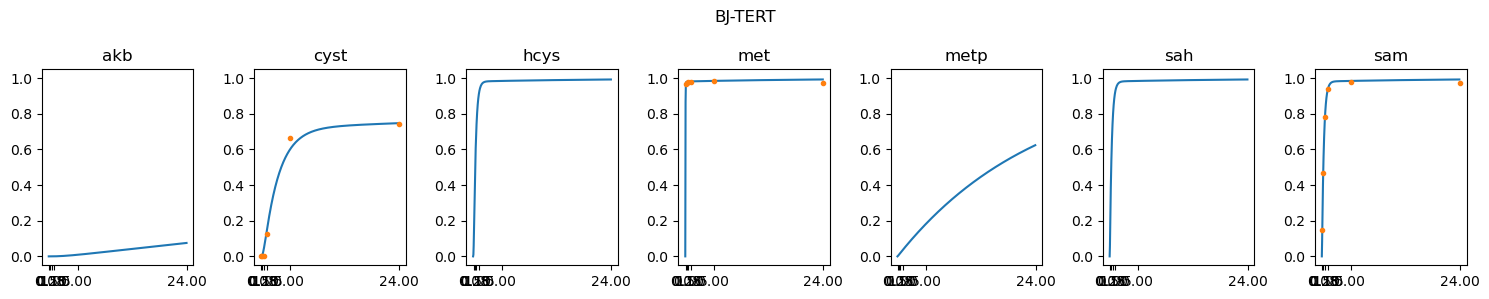

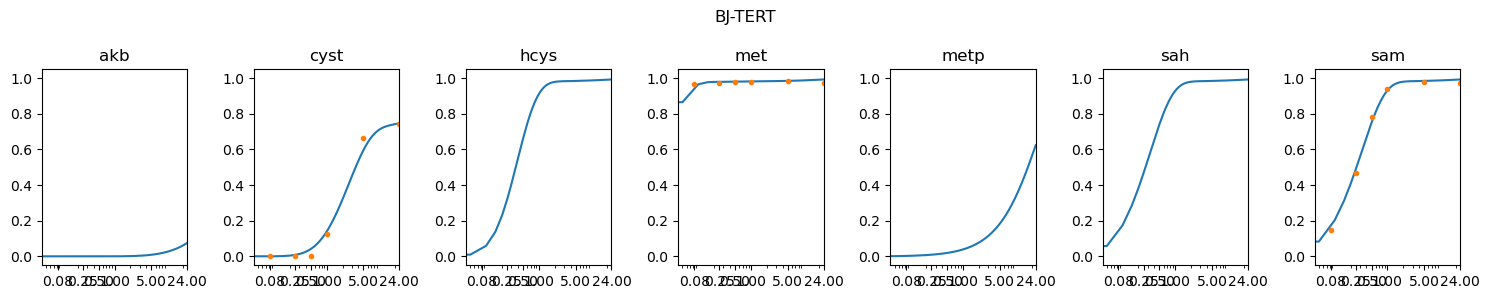

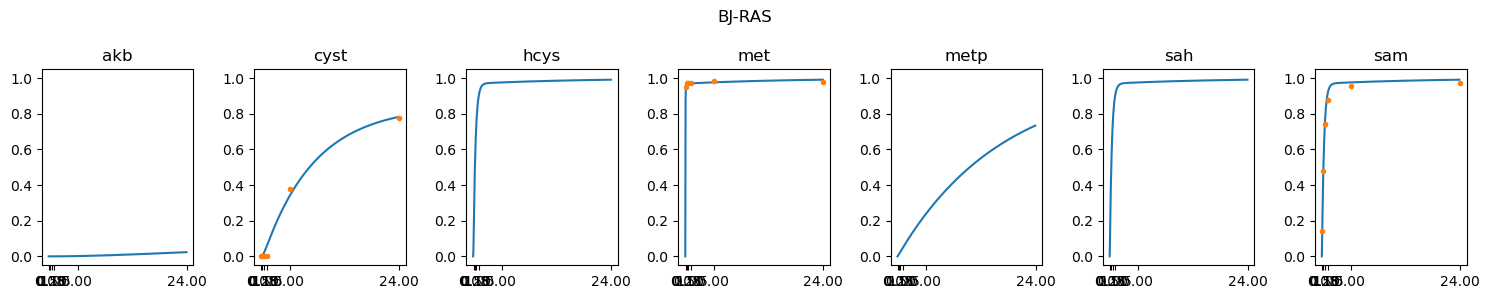

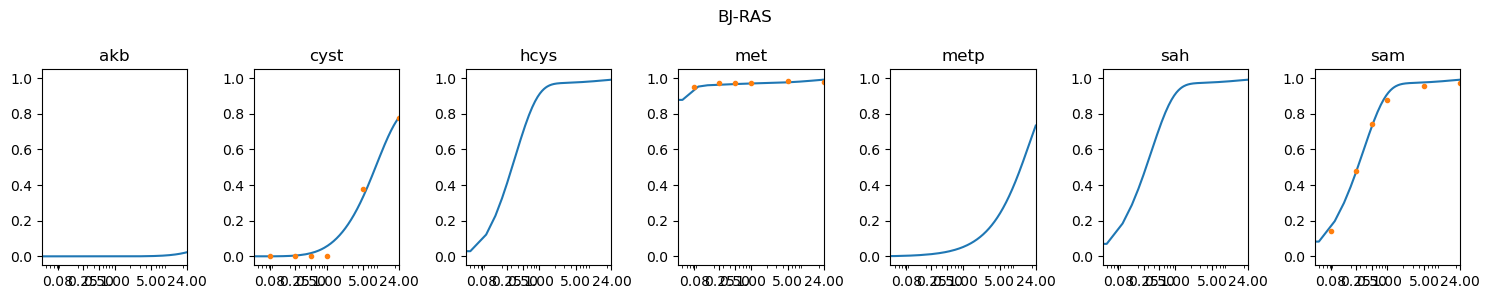

In [32]:
for cell_type in cell_types:
    for use_log_scale in [False, True]:
        plot_model_fit(
            flux_model, x_simulated.loc[cell_type], heavy_fraction_mean.loc[cell_type],
            use_log_scale=use_log_scale
        )
        plt.suptitle(cell_type)
        plt.tight_layout()
        plt.savefig(results_path / plot_file_name(cell_type, use_log_scale))

### Confidence intervals on estimated net fluxes
These are two-sided linearized confidence intervals, based on the parameter covariance from lmfit

In [33]:
ci_reactions = ['CYSTS', 'HCYS_OUT', 'METS', 'MET_IN', 'PROT_OUT', 'SAM_METH']
ci_table = pd.concat(
    [
        prepend_index_level(
            confidence_intervals_table(model_fits[cell_type], ci_level=0.9).loc[ci_reactions],
            cell_type, name='cell_type'
        )
        for cell_type in cell_types
    ]
)
ci_table

net     std err  ci_half-width    ci_lower  \
cell_type reaction                                                      
BJ-TERT   CYSTS       4.585573    0.851192       1.400086    3.185487   
          HCYS_OUT  115.050298   12.623728      20.764185   94.286113   
          METS       96.737016   28.073903      46.177461   50.559555   
          MET_IN    528.287516   91.819375     151.029432  377.258084   
          PROT_OUT  408.651644   90.899323     149.516081  259.135563   
          SAM_METH  216.372888   24.990855      41.106299  175.266588   
BJ-RAS    CYSTS       1.592210    0.285334       0.469333    1.122877   
          HCYS_OUT  106.111462   12.969272      21.332554   84.778908   
          METS      319.820189   77.787685     127.949356  191.870833   
          MET_IN    617.996425  127.593471     209.872584  408.123841   
          PROT_OUT  510.292753  126.934243     208.788250  301.504503   
          SAM_METH  427.523861   76.700120     126.160470  301.363391   

                      ci_upper  
cell_type reaction              
BJ-TERT   CYSTS       5.985660  
          HCYS_OUT  135.814484  
          METS      142.914477  
          MET_IN    679.316947  
          PROT_OUT  558.167725  
          SAM_METH  257.479187  
BJ-RAS    CYSTS       2.061543  
          HCYS_OUT  127.444015  
          METS      447.769546  
          MET_IN    827.869009  
          PROT_OUT  719.081003  
          SAM_METH  553.684332

In [34]:
# since seaborn (strangely) does not support drawing error bars from specified values,
# we provide the (max, min) range as values and plot using median (midrange) and max/min for error bars
ci_table_for_seaborn = ci_table[['ci_lower', 'ci_upper']].melt(ignore_index=False).sort_index(ascending=[False, True]).reset_index()
ci_table_for_seaborn

,cell_type,reaction,variable,value
0,BJ-TERT,CYSTS,ci_lower,3.185487
1,BJ-TERT,CYSTS,ci_upper,5.985660
2,BJ-TERT,HCYS_OUT,ci_lower,94.286113
3,BJ-TERT,HCYS_OUT,ci_upper,135.814484
4,BJ-TERT,METS,ci_lower,50.559555
5,BJ-TERT,METS,ci_upper,142.914477
6,BJ-TERT,MET_IN,ci_lower,377.258084
7,BJ-TERT,MET_IN,ci_upper,679.316947
8,BJ-TERT,PROT_OUT,ci_lower,259.135563
9,BJ-TERT,PROT_OUT,ci_upper,558.167725


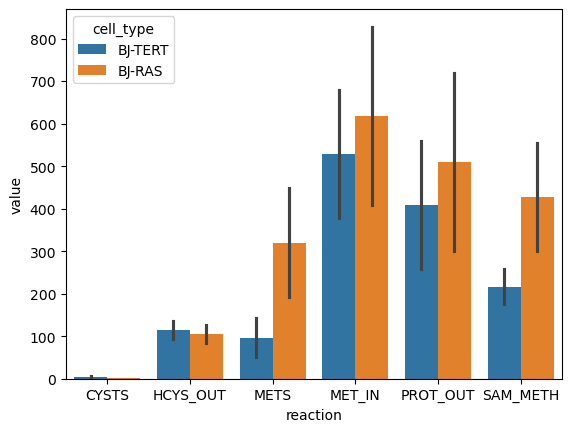

In [35]:
sns.barplot(
    ci_table_for_seaborn,
    x='reaction', y='value', hue='cell_type',
    estimator=np.median, errorbar=lambda x: [x.min(), x.max()]
)
plt.savefig(results_path / 'flux_ci.pdf')